# Example with estimation of lambda_ub

In [1]:
import copy
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
module_path_2 = os.path.abspath(os.path.join('../..'))
module_path_3 = os.path.abspath(os.path.join('./Scalable_VB_Hawkes/'))
module_path_4 = os.path.abspath(os.path.join('./NHGPS/'))
if module_path not in sys.path:
    sys.path.append(module_path)
if module_path_2 not in sys.path:
    sys.path.append(module_path_2)
if module_path_3 not in sys.path:
    sys.path.append(module_path_3)
if module_path_4 not in sys.path:
    sys.path.append(module_path_4)

from src.NL_hawkes import NonlinHawkesBasis, LinkFunction
from src.utils import nb_excursions, gq_points_weights, nd_block_diag, intensity_process, log_likelihood

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from scipy.stats import gamma, norm, beta
from time import time
from scipy.special import expit
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
from scipy import optimize
import json
import pickle
import arviz as az
from types import SimpleNamespace
from pathlib import PosixPath
import yaml

### Create simulated data set

In [2]:
# General parameters
number_of_dimensions=1
number_of_basis=4
A=1.0
basis='histogram'
T=4000
nl_models = {
    "sigmoid": {"theta": 0.0, "beta": 1.0, "eta": 0.0, "lamda":1.0 },
}
link = 'sigmoid'

In [3]:
# Model parameters
if number_of_dimensions > 1:
    base_activation = np.array([5., 4.0] * (number_of_dimensions // 2) ) # background rates
    graph_2D = np.array([[1, 1],[0, 1]], dtype=np.int64)
    graph = scipy.linalg.block_diag(*([graph_2D] * (number_of_dimensions //2))) # graph of interaction
    full_graph = np.ones((number_of_dimensions,number_of_dimensions), dtype=int)
    w01 = np.linspace(3,2,num=number_of_basis).reshape(1,-1)
    w02 = np.linspace(2,1,num=number_of_basis).reshape(1,-1)
    w03 = np.linspace(-3,-2,num=number_of_basis).reshape(1,-1)
    block_exc = np.concatenate([w01, w02, w02, w01], axis=0).reshape(2, 2, -1)
    block_inh = np.concatenate([w03, w02, w02, w03], axis=0).reshape(2, 2, -1)
    weight = {
        'exc': nd_block_diag([block_exc]*(number_of_dimensions//2)),
        'inh':  nd_block_diag([block_inh]*(number_of_dimensions//2)),
        }
else:
    base_activation = np.array([-2.] )
    graph = np.array([[1]])
    w01 = np.linspace(3,1,num=number_of_basis).reshape(1,-1)
    w02 = np.linspace(2,1,num=number_of_basis).reshape(1,-1)
    w03 = np.linspace(-3,-2,num=number_of_basis).reshape(1,-1)
    weight = {
        'exc': w01,
        'inh': w03,
        }
    lamda_ub = 2.0

N_param = len(base_activation) + weight['exc'].size
print("Number of model parameters : ", N_param)

# Choose scenario: excitation or inhibition
scenario = 'exc'

# Interaction functions
sparse_weight = np.expand_dims(graph, axis=2) * weight[scenario]

Number of model parameters :  5


In [4]:
# Initialise and simulate from process
model = SimpleNamespace(**nl_models[link])
t0 = time()
hawkes_model = NonlinHawkesBasis(number_of_dimensions, number_of_basis, A, model=link, basis=basis,
                              theta=model.theta, beta=model.beta, lamda=lamda_ub, eta=model.eta)
hawkes_model.set_hawkes_parameters(base_activation, sparse_weight)
points_hawkes = hawkes_model.simulation(T=T)

# Remove "initial condition" to observe stationary distribution
T_init = 10
T = T - T_init
for d in range(len(points_hawkes)):
    points_hawkes[d] = points_hawkes[d][points_hawkes[d] > T_init] - T_init

# number of points on each dimension
N = np.array([len(points_hawkes[i]) for i in range(number_of_dimensions)])

print(f'Time for simulating the process: {time() - t0} sec')
print(f"Number of events : ", np.sum(N))
print(f"Number of excursions : ", nb_excursions(points_hawkes, A))

Time for simulating the process: 1.3701541423797607 sec
Number of events :  2444
Number of excursions :  684


In [5]:
# Save dataset
save_dir_data = f'/data/hylacola/sulem/PycharmProjects/Scalable_VB_Hawkes/data/synthetic_data/dataset_histo_dim{number_of_dimensions}_T_{T}/'
save_dir_data = PosixPath(save_dir_data).expanduser()
if not os.path.isdir(save_dir_data):
    os.makedirs(save_dir_data)
with open(save_dir_data / f'data.p', 'wb') as fp:
    pickle.dump(points_hawkes, fp)

### Apply inference method

In [6]:
# General prior parameters
mu = 0.0 # mean
sigma= 5.0 # variance

num_iter = 40 # number of VI iterations
depth = 5 # depth of nested histogram basis

num_gq = 5000 # number of Gaussian quadrature points
threshold = 0.05

In [22]:
# Run first algorithm
t0 = time()
mean_nu_1, mean_weight_1, cov_1, lamda_ub_1 = hawkes_model.AdaptiveVB(points_hawkes, T=T, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth, estimate_lambda=True)
# mean_nu_1, mean_weight_1, cov_1= hawkes_model.AdaptiveVB(points_hawkes, T=T, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth, estimate_lambda=False)
# lamda_ub_1 = [lamda_ub]

print(f'Time of first VI algo: {time() - t0} sec')

Initialisation...
Number of graph parameters: 2
Number of 'models': 7
Starting MF-VI...
Model with graph parameter: [[0]] and 0 basis functions
Initialisation...
Iteration  0
ELBO: -inf
Iteration  1
ELBO: -5904.59260209569
Iteration  2
ELBO: -3650.5068233345564
Iteration  3
ELBO: -3646.2034157338167
Iteration  4
ELBO: -3646.1904607824226
Iteration  5
ELBO: -3646.1903839438355
Iteration  6
ELBO: -3646.190380635498
Iteration  7
ELBO: -3646.190379501958
Iteration  8
ELBO: -3646.1903784800734
Iteration  9
ELBO: -3646.190377464574
Iteration  10
ELBO: -3646.190376449847
Iteration  11
ELBO: -3646.190375435592
Iteration  12
ELBO: -3646.1903744217925
Iteration  13
ELBO: -3646.190373408447
Iteration  14
ELBO: -3646.1903723955584
Iteration  15
ELBO: -3646.1903713831225
Iteration  16
ELBO: -3646.19037037114
Iteration  17
ELBO: -3646.1903693596128
Iteration  18
ELBO: -3646.1903683485384
Iteration  19
ELBO: -3646.190367337918
Iteration  20
ELBO: -3646.19036632775
Iteration  21
ELBO: -3646.1903653180

In [23]:
# Save result in a new Hawkes model
mean_weight_1 = mean_weight_1.reshape(number_of_dimensions, number_of_dimensions, -1)
model_1 = hawkes_model.set_of_models[np.argmax(hawkes_model.vpost_proba)]
vi_model_1 = NonlinHawkesBasis(number_of_dimensions, model_1[1], A, model=link, basis=basis,
                               theta=model.theta, beta=model.beta, lamda=lamda_ub_1, eta=model.eta)
vi_model_1.set_hawkes_parameters(mean_nu_1, mean_weight_1)
vi_model_1.set_of_models = hawkes_model.set_of_models
vi_model_1.vpost_proba = hawkes_model.vpost_proba
print(f'Estimated graph: ', model_1[0])
print(f'Number of basis functions: ', model_1[1])

Estimated graph:  [[1]]
Number of basis functions:  4


In [26]:
# Run second algorithm
# t0 = time()
# mean_nu_2, mean_weight_2, cov_2 = hawkes_model.FastAdaptiveVB(points_hawkes, T=T, threshold=threshold, num_gq=num_gq, num_iter=num_iter, sigma=sigma, depth=depth)
# mean_weight_2 = mean_weight_2.reshape(number_of_dimensions, number_of_dimensions, -1)
# model_2 = hawkes_model.set_of_models[np.argmax(hawkes_model.vpost_proba)]
# vi_model_2 = NonlinHawkesBasis(number_of_dimensions, model_2[1], A, model=link, basis=basis,
#                                theta=model.theta, beta=model.beta, lamda=model.lamda, eta=model.eta)
# vi_model_2.set_hawkes_parameters(mean_nu_2, mean_weight_2)
# vi_model_2.set_of_models = hawkes_model.set_of_models
# vi_model_2.vpost_proba = hawkes_model.vpost_proba
# print(f'Time of second VI algo: {time() - t0} sec')
# print(f'Estimated graph: ', model_2[0])
# print(f'Number of basis functions: ', model_2[1])

### Visualise results

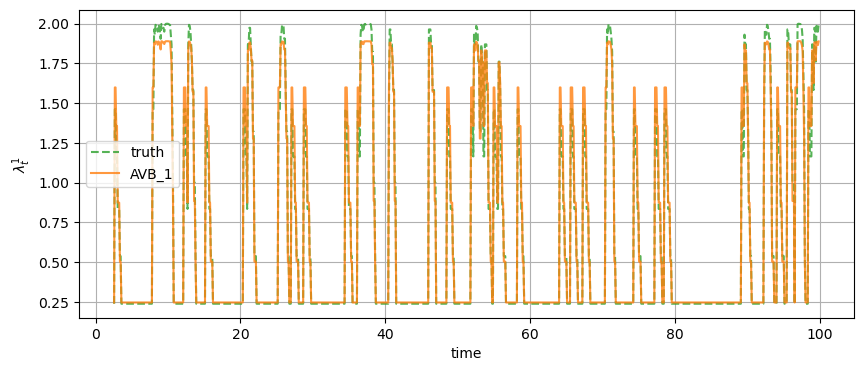

In [27]:
# Estimated intensity using mean variational posterior estimate
Tmax = 100
points_hawkes_tmax = [points_hawkes[i][points_hawkes[i] < Tmax] for i in range(len(points_hawkes))]

# using first VI algorithm
vi_intensity_1, timestamps  = intensity_process(vi_model_1, points_hawkes_tmax)

# using second VI algorithm
#vi_intensity_2, timestamps  = intensity_process(vi_model_2, points_hawkes_tmax)

# True intensity
true_intensity, timestamps = intensity_process(hawkes_model, points_hawkes_tmax)


fig, ax = plt.subplots(number_of_dimensions, 1, figsize=(10, 4))
for i in range(number_of_dimensions):
    if number_of_dimensions > 1:
        a = ax[i]
    else:
        a = ax
    a.plot(timestamps, true_intensity[i], label=f'truth', alpha=0.8, color='tab:green', linestyle='dashed')
    a.plot(timestamps,  vi_intensity_1[i], label=f'AVB_1', alpha=0.8, color='tab:orange')
    #a.plot(timestamps, vi_intensity_2[i], label=f'AVB_2', alpha=0.8, color='tab:blue')
    a.set_xlabel('time')
    a.set_ylabel(rf'$\lambda^{i+1}_t$')
    a.grid()
a.legend()

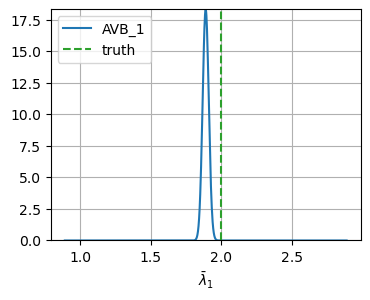

In [28]:
# lambda max
fig, ax = plt.subplots(1, number_of_dimensions, figsize=(4* number_of_dimensions,3))
for i in range(number_of_dimensions):
    if number_of_dimensions == 1:
        a = ax
    else:
        a = ax[i]
    x = np.linspace(lamda_ub_1[i]-1, lamda_ub_1[i]+1, 1000)
    q1_lambda = gamma.pdf(x, a=lamda_ub_1[0]*T, scale=1/T)
    a.plot(x, q1_lambda, label='AVB_1')
    ymax = max(q1_lambda)
    a.set_ylim(0,ymax)
    a.vlines(x=lamda_ub, ymin=0, ymax=ymax, linestyles='dashed', label='truth', color='tab:green')
    a.legend(loc='upper left')
    a.grid(visible=True)
    a.set_xlabel(rf'$\bar \lambda_{i+1}$')

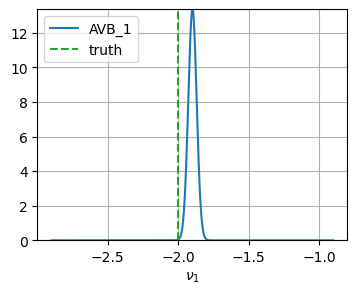

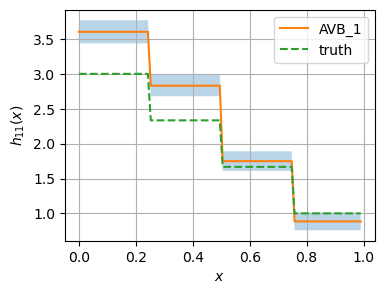

In [29]:
# Estimated parameter

# background rates
fig, ax = plt.subplots(1, number_of_dimensions, figsize=(4* number_of_dimensions,3))
for i in range(number_of_dimensions):
    if number_of_dimensions == 1:
        a = ax
    else:
        a = ax[i]
    x = np.linspace(mean_nu_1[i]-1, mean_nu_1[i]+1, 1000)
    q1_nu = norm.pdf(x, loc=mean_nu_1[i], scale=np.sqrt(cov_1[i][0,0]))
    a.plot(x, q1_nu, label='AVB_1')
    # q2_nu = norm.pdf(x, loc=mean_nu_2[i], scale=np.sqrt(cov_2[i][0,0]))
    # a.plot(x, q2_nu, label='AVB_2')
    ymax = max(q1_nu) # max(max(q1_nu), max(q2_nu))
    a.set_ylim(0,ymax)
    a.vlines(x=base_activation[i], ymin=0, ymax=ymax, linestyles='dashed', label='truth', color='tab:green')
    a.legend(loc='upper left')
    a.grid(visible=True)
    a.set_xlabel(rf'$\nu_{i+1}$')



# interaction functions
if basis == 'fourier':
    fb = Fourier(domain_range=[0, A], n_basis=number_of_basis,period=A)
elif basis == 'histogram':
    bins_true = np.linspace(0, A, num=number_of_basis+1)
else:
    raise ValueError
x = np.linspace(0, A, num=100)[:-1]
y_true = np.digitize(x, bins=bins_true) - 1

bins_m1 = np.linspace(0, A, num=model_1[1]+1)
y1 = np.digitize(x, bins=bins_m1) - 1
# bins_m2 = np.linspace(0, A, num=model_2[1]+1)
# y2 = np.digitize(x, bins=bins_m2) - 1

fig, ax = plt.subplots(number_of_dimensions,number_of_dimensions , figsize=(4*number_of_dimensions,3*number_of_dimensions))
for i in range(number_of_dimensions):
    for j in range(number_of_dimensions):
        if number_of_dimensions == 1:
            a = ax
        else:
            a = ax[i,j]

        std_w1 = np.sqrt(np.diag(cov_1[i]))[1+j*model_1[1]:1+(j+1)*model_1[1]]
        a.plot(x, mean_weight_1[i,j][y1], label='AVB_1', color='tab:orange')
        a.fill_between(x, (mean_weight_1[i,j] - 1.96*std_w1)[y1], (mean_weight_1[i,j] + 1.96*std_w1)[y1], alpha=0.3)

        # std_w2 = np.sqrt(np.diag(cov_2[i]))[1+j*model_2[1]:1+(j+1)*model_2[1]]
        # a.plot(x, mean_weight_2[i,j][y2], label='AVB_2', color='tab:blue')
        # a.fill_between(x, (mean_weight_2[i,j] - 1.96*std_w2)[y2], (mean_weight_2[i,j] + 1.96*std_w2)[y2], alpha=0.3)

        a.plot(x, sparse_weight[i][j][y_true], label='truth',  color='tab:green', linestyle='dashed')
        a.set_xlabel(r'$x$')
        a.grid(visible=True)
        id_latex=(i+1)*10+(j+1)
        a.set_ylabel(r'$h_{{{}}}(x)$'.format(id_latex))
a.legend()


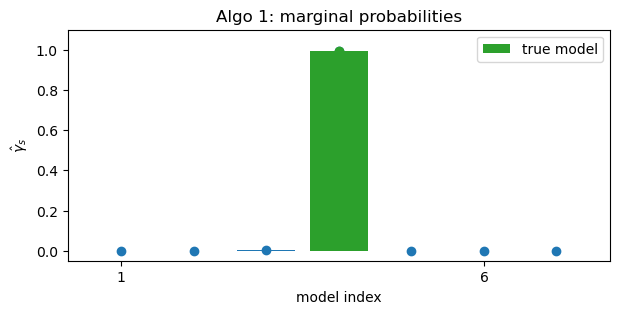

In [30]:
# 'Models' marginal probabilities
for i,m in enumerate(vi_model_1.set_of_models):
    if (m[0] == graph).all() and m[1] == number_of_basis:
        true_model1 = i

# for i,m in enumerate(vi_model_2.set_of_models):
#     if (m[0] == graph).all() and m[1] == number_of_basis:
#         true_model2 = i

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_title("Algo 1: marginal probabilities")
ax.bar(x=range(1,len(vi_model_1.vpost_proba)+1), height=vi_model_1.vpost_proba, color='tab:blue')
ax.scatter(x=range(1,len(vi_model_1.vpost_proba)+1), y=vi_model_1.vpost_proba, color='tab:blue')
ax.bar(x=true_model1+1, height=vi_model_1.vpost_proba[true_model1], color='tab:green', label="true model")
ax.scatter(x=true_model1+1, y=vi_model_1.vpost_proba[true_model1], color='tab:green')
ax.set_xlabel('model index')
ax.set_ylabel(r'$\hat \gamma_{s}$')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(np.arange(1,len(vi_model_1.vpost_proba),5))
ax.legend()

# fig, ax = plt.subplots(1, 1, figsize=(7, 3))
# ax.set_title("Algo 2: marginal probabilities")
# ax.bar(x=range(1,len(vi_model_2.vpost_proba)+1), height=vi_model_2.vpost_proba, color='tab:orange')
# ax.scatter(x=range(1,len(vi_model_2.vpost_proba)+1), y=vi_model_2.vpost_proba, color='tab:orange')
# ax.bar(x=true_model2+1, height=vi_model_2.vpost_proba[true_model2], color='tab:green', label="true model")
# ax.scatter(x=true_model2+1, y=vi_model_2.vpost_proba[true_model2], color='tab:green')
# ax.set_xlabel('model index')
# ax.set_ylabel(r'$\hat \gamma_{s}$')
# ax.set_ylim(-0.05, 1.1)
# ax.set_xticks(np.arange(1,len(vi_model_2.vpost_proba)+1,len(vi_model_2.vpost_proba)//5+1))
# ax.legend()